In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from yellowbrick.classifier import ConfusionMatrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.target import FeatureCorrelation
from scipy.stats import pearsonr
from scipy.interpolate import interpn
from scipy.stats import gaussian_kde, pearsonr
#plot configuration
# import sys
# sys.path.append('/Users/allen/Documents/Python/PlotGallary/')
# from matplotlibconfig import basic
# basic()

In [4]:
# utilities
def scatter(x,y, axes=None, **figkwargs):
    '''
    Make density scatter plot
    Args:
    ---------------
    :x - numpy.array object (None, 1)
    :y - numpy.array object (None, 1)

    Returns:
    ---------------
    :fig - matplotlib.pyplot object
    :axes - axes for the figure
    
    Example:
    ---------------
    Case 1: produce one graph with one axes
    fig, ax= scatter(x, y)
    
    Case 2: produce multiple axes
    fig= plt.figure()
    ax1= fig.add_subplot(121)
    scatter(x1,y1,ax1)
    ax2= fig.add_subplot(122)
    scatter(x2,y2,ax2)
    
    '''

    _max= max(x.max(), y.max())
    _min= min(x.min(), y.min())
    if axes is None:
        fig= plt.figure()
        axes= fig.add_subplot()
    else:
        fig= plt.gcf()
    data, x_e, y_e= np.histogram2d(x, y, bins=50)
    z= interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) ,
        data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )
    idx= z.argsort() #move high density forward
    x, y, z= x[idx], y[idx], z[idx]
    ax= axes.scatter(x, y, c= z, s=200, edgecolor= '', cmap='jet', **figkwargs)
    axes.set_aspect('equal', 'box')
    axes.plot([_min, _max],[_min, _max], c='r')
    axes.set_xlim([_min, _max])
    axes.set_ylim([_min, _max])    
    cb= plt.colorbar(orientation='vertical', mappable=ax, shrink=.7)

    return fig, axes

def rmse(x,y):
    return ((((x-y)**2).sum())/len(x))**.5

def r(x,y):
    return pearsonr(x, y)[0]

def mae(x,y):
    return (np.abs(x-y).sum())/len(x)

def bias(x,y):
    return (x-y).sum()/y.sum()*100

def makeTrainTestData(X, y, **kwargs):
    Xtrain, Xtest, ytrain, ytest= train_test_split(X, y, test_size=.3, random_state=3, **kwargs)
    
    return Xtrain, Xtest, ytrain, ytest

def colordensityPlot(ysimTrain, ysimTest, ytrain, ytest):
    fig = plt.figure(figsize=(12,6))
    ax= fig.add_subplot(121)
    fig, ax= scatter(ysimTrain, ytrain, ax)
    ax.set_xlabel('Predicted (mm/h)')
    ax.set_ylabel('Reference (mm/h)')
    ax.text(0.5,0.6, 'RMSE: %.2f mm/h\nCC: %.2f'%(rmse(ysimTrain, ytrain), pearsonr(ysimTrain, ytrain)[0]),
           transform=ax.transAxes)
    ax= fig.add_subplot(122)
    fig, ax= scatter(ysimTest, ytest, ax)
    ax.set_xlabel('Predicted (mm/h)')
    ax.set_ylabel('Reference (mm/h)')
    ax.text(0.5,0.6, 'RMSE: %.2f mm/h\nCC: %.2f'%(rmse(ysimTest, ytest), pearsonr(ysimTest, ytest)[0]),
           transform=ax.transAxes)
    
    return fig, ax

In [24]:
df= pd.read_csv('updatedDataFrame.csv').drop('Unnamed: 0', axis=1)

In [25]:
df.head()

,c1_amsua,c2_amsua,c15_amsua,c1_amsub,c2_amsub,c3_amsub,c4_amsub,c5_amsub,aver_precip_nssl,rr_amsub,...,dem,lon,lat,angle,date,time,classes,month,coasts,diurnal
0,22229.0,22195.0,22684.0,22010.0,22935.0,24196.0,24836.0,24680.0,0.174699,-13.0,...,0.0,-67.6,49.3,88.0,2012-03-01,639,0,3,1,6
1,23081.0,22960.0,22897.0,23113.0,23066.0,24013.0,24916.0,24313.0,0.108333,-13.0,...,448.0,-67.8,47.9,88.0,2012-03-01,639,0,3,0,6
2,17153.0,17062.0,21958.0,21236.0,23719.0,24015.0,25208.0,25763.0,0.227532,0.0,...,0.0,-64.8,43.6,81.0,2012-03-01,639,3,3,0,6
3,17153.0,17062.0,21958.0,23639.0,24993.0,24107.0,25189.0,25892.0,0.186869,0.0,...,0.0,-65.2,43.7,82.0,2012-03-01,639,3,3,1,6
4,17783.0,17615.0,23027.0,20930.0,23822.0,24088.0,25295.0,25910.0,0.252813,0.0,...,0.0,-64.8,43.5,81.0,2012-03-01,639,3,3,0,6


# Benchmark

Text(2, 2, 'RMSE: 39.90 mm/h\nCC: 0.30')

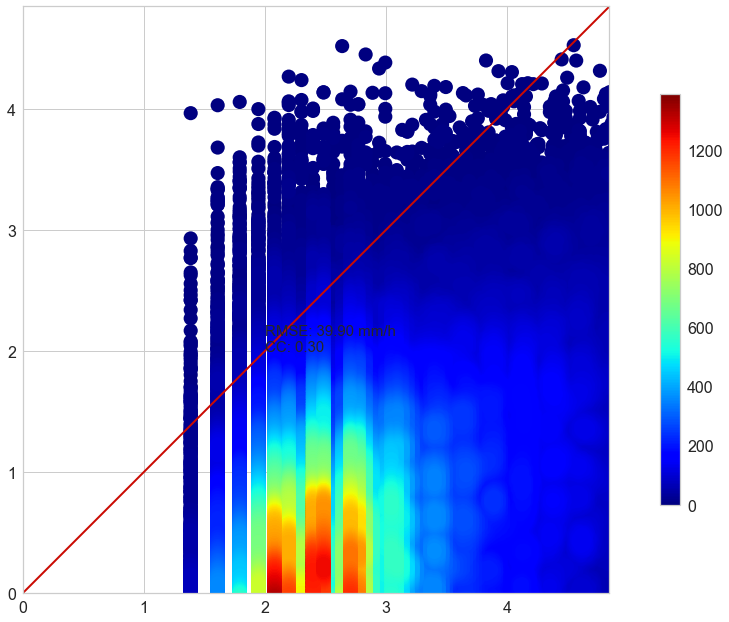

In [32]:
fig, ax= scatter(np.log(df.rr_amsub[df.rr_amsub>0].values), np.log(df.aver_precip_nssl[df.rr_amsub>0].values))
ax.text(2,2, 'RMSE: %.2f mm/h\nCC: %.2f'%(rmse(df.rr_amsub[df.rr_amsub>0].values, df.aver_precip_nssl[df.rr_amsub>0]),
                                          pearsonr(df.rr_amsub[df.rr_amsub>0].values, df.aver_precip_nssl[df.rr_amsub>0])[0]))

# Simulation 1 - Local features

In [11]:
Xtrain, Xtest, ytrain, ytest= makeTrainTestData(df.loc[:,['c1_amsua', 'c2_amsua', 'c15_amsua',
                                                         'c1_amsub', 'c2_amsub','c3_amsub',
                                                         'c4_amsub', 'c5_amsub']], df.aver_precip_nssl.values)

In [36]:
rf= RandomForestRegressor(n_estimators=100, max_depth=50, n_jobs=-1)
rf.fit(Xtrain.loc[:, ['c1_amsua', 'c2_amsua', 'c15_amsua',
                        'c1_amsub', 'c2_amsub','c3_amsub',
                        'c4_amsub', 'c5_amsub']], ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [40]:
ysimTrain= rf.predict(Xtrain.loc[:, ['c1_amsua', 'c2_amsua', 'c15_amsua',
                        'c1_amsub', 'c2_amsub','c3_amsub',
                        'c4_amsub', 'c5_amsub']])
ysimTest= rf.predict(Xtest.loc[:, ['c1_amsua', 'c2_amsua', 'c15_amsua',
                        'c1_amsub', 'c2_amsub','c3_amsub',
                        'c4_amsub', 'c5_amsub']])

Text(0.05, 1.02, 'BIAS: 9.55%\nMAE: 1.04 mm/h\nRMSE: 2.34 mm/h\nCC: 0.44')

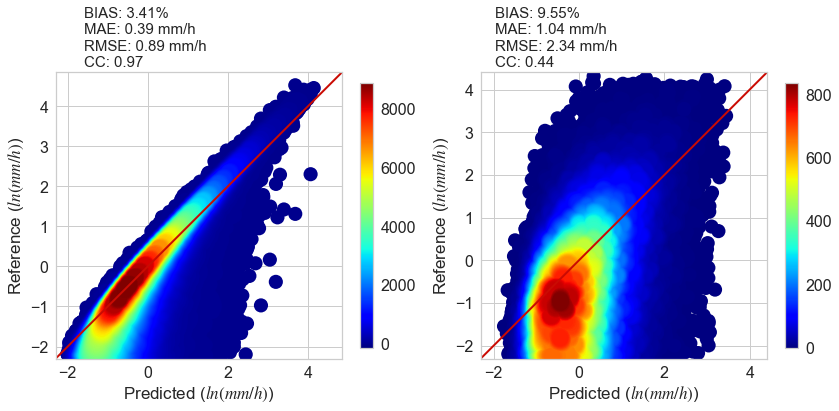

In [41]:
fig = plt.figure(figsize=(12,6))
ax= fig.add_subplot(121)
fig, ax= scatter(np.log(ytrain), np.log(ysimTrain), ax)
ax.set_xlabel('Reference ($ln(mm/h)$)')
ax.set_ylabel('Predicted ($ln(mm/h)$)')
ax.text(0.1,1.02, 'BIAS: %.2f'%bias(ysimTrain, ytrain)+'%'+'\nMAE: %.2f mm/h\nRMSE: %.2f mm/h\nCC: %.2f'%(
         mae(ysimTrain, ytrain), rmse(ysimTrain, ytrain), pearsonr(ysimTrain, ytrain)[0]),
       transform=ax.transAxes)
ax= fig.add_subplot(122)
fig, ax= scatter(np.log(ytest), np.log(ysimTest), ax)
ax.set_xlabel('Reference ($ln(mm/h)$)')
ax.set_ylabel('Predicted ($ln(mm/h)$)')
ax.text(0.05,1.02, 'BIAS: %.2f'%bias(ysimTest, ytest)+'%'+'\nMAE: %.2f mm/h\nRMSE: %.2f mm/h\nCC: %.2f'%(
        mae(ysimTest, ytest), rmse(ysimTest, ytest), pearsonr(ysimTest, ytest)[0]),
       transform=ax.transAxes)

In [46]:
fig.savefig('simulation1_densityPlot.png', dpi=144)

# Simulation 2 - Local features + nonLocal Features +auxilary info

In [6]:
Xtrain, Xtest, ytrain, ytest= makeTrainTestData(df.drop([
                                                'date', 'time', 'aver_precip_nssl', 'rr_amsub',
                                                'classes', 'month','coasts'
                                                    ], axis=1), df.aver_precip_nssl.values)

In [7]:
rf= RandomForestRegressor(n_estimators=100, max_depth=50, n_jobs=-1)
rf.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [8]:
ysimTrain= rf.predict(Xtrain)
ysimTest= rf.predict(Xtest)

Text(0.05, 1.02, 'BIAS: 10.33%\nMAE: 1.00 mm/h\nRMSE: 2.29 mm/h\nCC: 0.49')

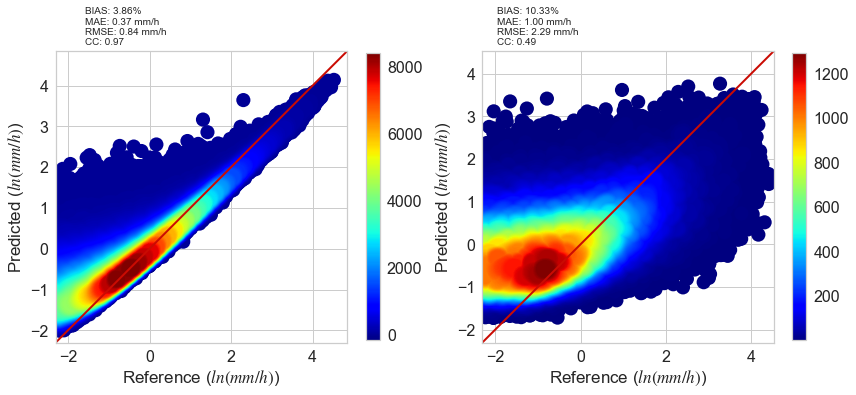

In [10]:
fig = plt.figure(figsize=(12,6))
ax= fig.add_subplot(121)
fig, ax= scatter(np.log(ytrain), np.log(ysimTrain), ax)
ax.set_xlabel('Reference ($ln(mm/h)$)')
ax.set_ylabel('Predicted ($ln(mm/h)$)')
ax.text(0.1,1.02, 'BIAS: %.2f'%bias(ysimTrain, ytrain)+'%'+'\nMAE: %.2f mm/h\nRMSE: %.2f mm/h\nCC: %.2f'%(
         mae(ysimTrain, ytrain), rmse(ysimTrain, ytrain), pearsonr(ysimTrain, ytrain)[0]),
       transform=ax.transAxes)
ax= fig.add_subplot(122)
fig, ax= scatter(np.log(ytest), np.log(ysimTest), ax)
ax.set_xlabel('Reference ($ln(mm/h)$)')
ax.set_ylabel('Predicted ($ln(mm/h)$)')
ax.text(0.05,1.02, 'BIAS: %.2f'%bias(ysimTest, ytest)+'%'+'\nMAE: %.2f mm/h\nRMSE: %.2f mm/h\nCC: %.2f'%(
        mae(ysimTest, ytest), rmse(ysimTest, ytest), pearsonr(ysimTest, ytest)[0]),
       transform=ax.transAxes)

In [58]:
fig.savefig('simulation2_densityPlot.png', dpi=144)

# Simulation 3 plus simulated classes

In [37]:
df.drop('sim_classes', axis=1, inplace=True)

In [38]:
Xtrain, Xtest, ytrain, ytest= makeTrainTestData(df.drop([
                                                'date', 'time', 'aver_precip_nssl', 'rr_amsub',
                                                'classes', 'month','coasts'
                                                    ], axis=1), df.classes.values, stratify= df.classes.values)

In [39]:
randomforestCls= RandomForestClassifier(n_estimators=500, max_depth=50,
                                        max_features='log2', n_jobs=30,
                                        class_weight='balanced')
randomforestReg= RandomForestRegressor(n_estimators=500, max_depth=50, n_jobs=30)

In [40]:
randomforestCls.fit(Xtrain, ytrain)
sim_cls= randomforestCls.predict(df.drop(['date', 'time', 'aver_precip_nssl', 'rr_amsub',
                                            'classes', 'month','coasts'], axis=1))
df['sim_classes']= sim_cls

In [41]:
Xtrain, Xtest, ytrain, ytest= makeTrainTestData(df.drop([
                                                'date', 'time', 'aver_precip_nssl', 'rr_amsub',
                                                'classes', 'month','coasts'
                                                    ], axis=1), df.aver_precip_nssl.values)
randomforestReg.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=30, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [42]:
ysimTrain= randomforestReg.predict(Xtrain)
ysimTest= randomforestReg.predict(Xtest)

In [32]:
import joblib
joblib.dump(randomforestCls, 'randomforestClassifier.pkl')
joblib.dump(randomforestReg, 'randomforestRegressor.pkl')

['randomforestRegressor.pkl']

Text(0.05, 1.02, 'BIAS: 8.34%\nMAE: 0.88 mm/h\nRMSE: 2.02 mm/h\nCC: 0.64')

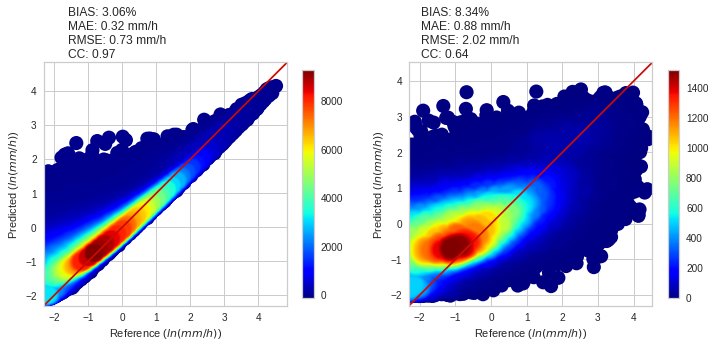

In [43]:
fig = plt.figure(figsize=(12,6))
ax= fig.add_subplot(121)
fig, ax= scatter(np.log(ytrain), np.log(ysimTrain), ax)
ax.set_xlabel('Reference ($ln(mm/h)$)')
ax.set_ylabel('Predicted ($ln(mm/h)$)')
ax.text(0.1,1.02, 'BIAS: %.2f'%bias(ysimTrain, ytrain)+'%'+'\nMAE: %.2f mm/h\nRMSE: %.2f mm/h\nCC: %.2f'%(
         mae(ysimTrain, ytrain), rmse(ysimTrain, ytrain), pearsonr(ysimTrain, ytrain)[0]),
       transform=ax.transAxes)
ax= fig.add_subplot(122)
fig, ax= scatter(np.log(ytest), np.log(ysimTest), ax)
ax.set_xlabel('Reference ($ln(mm/h)$)')
ax.set_ylabel('Predicted ($ln(mm/h)$)')
ax.text(0.05,1.02, 'BIAS: %.2f'%bias(ysimTest, ytest)+'%'+'\nMAE: %.2f mm/h\nRMSE: %.2f mm/h\nCC: %.2f'%(
        mae(ysimTest, ytest), rmse(ysimTest, ytest), pearsonr(ysimTest, ytest)[0]),
       transform=ax.transAxes)

In [60]:
fig.savefig('simulation3_densityPlot.png', dpi=144)

# Feature importance

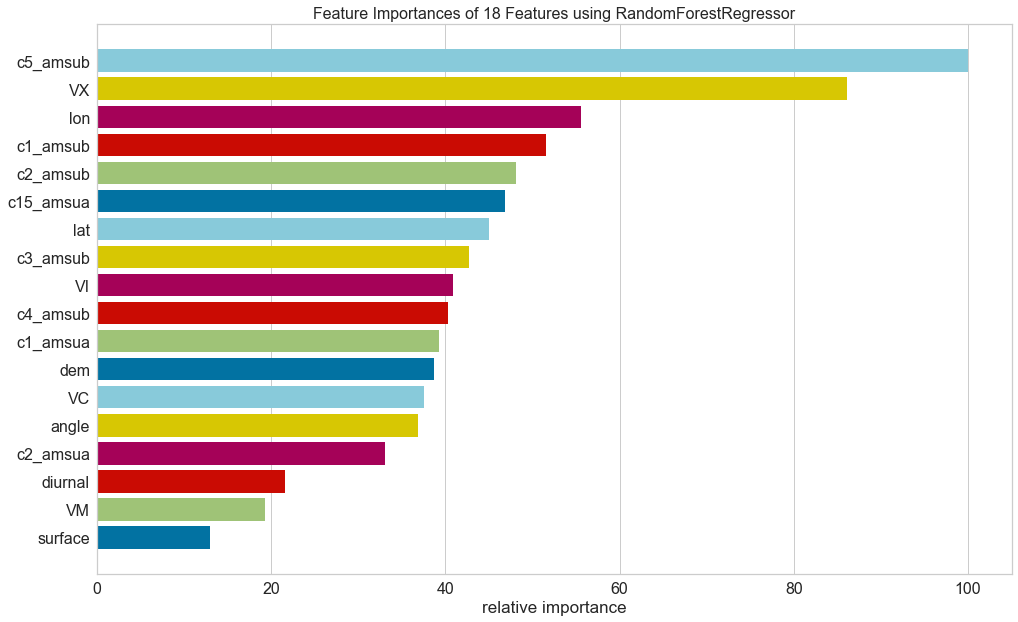

In [66]:
viz = FeatureImportances(rf)
viz.fit(df.drop(['date', 'time', 'aver_precip_nssl', 'rr_amsub',
                'classes', 'month','coasts', 'sim_classes'], axis=1), df.aver_precip_nssl.values)
viz.show('featureImportanceSim2Reg.pdf')

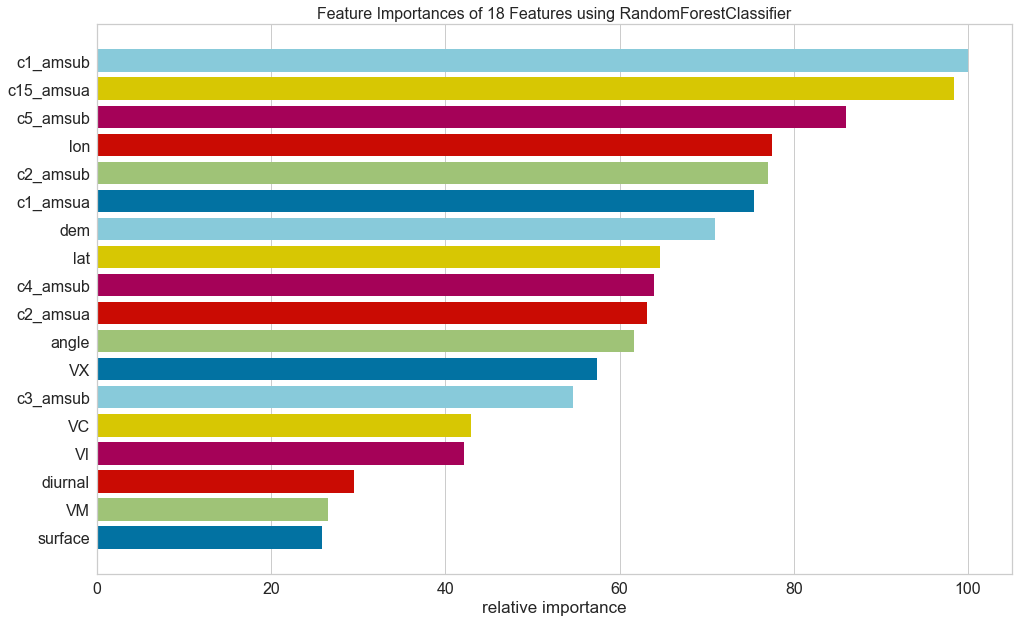

In [71]:
viz = FeatureImportances(RandomForestClassifier(n_estimators=10))
viz.fit(df.drop(['date', 'time', 'aver_precip_nssl', 'rr_amsub',
                'classes', 'month','coasts', 'sim_classes'], axis=1), df.classes.values)
viz.show()

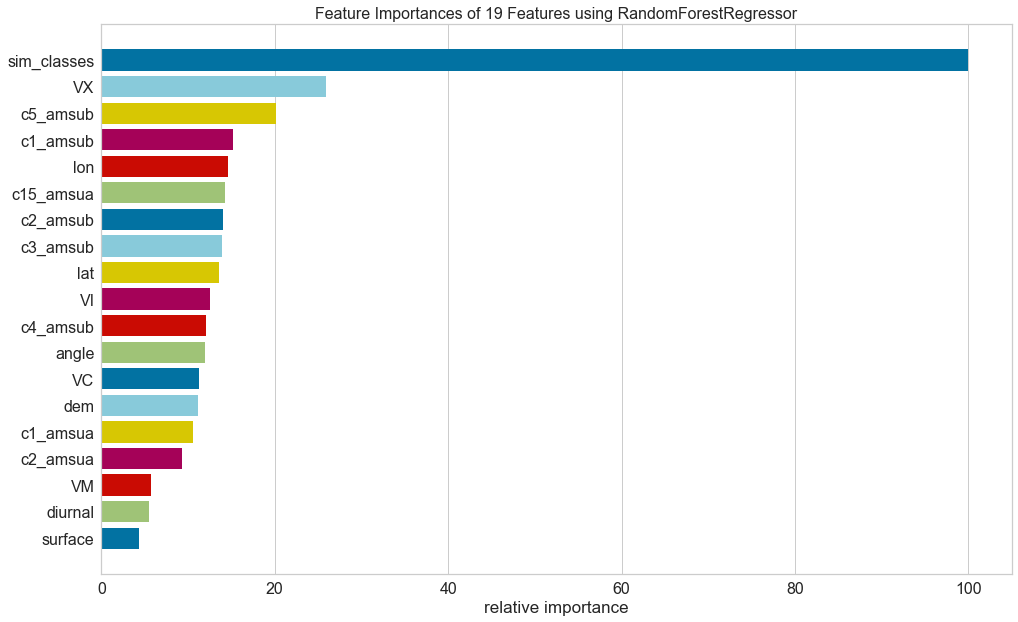

In [73]:
viz = FeatureImportances(RandomForestRegressor(n_estimators=10, n_jobs=-1))
viz.fit(df.drop(['date', 'time', 'aver_precip_nssl', 'rr_amsub',
                'classes', 'month','coasts'], axis=1), df.aver_precip_nssl.values)
viz.show()

In [74]:
df.drop('sim_classes', axis=1, inplace=True)

## Crossvalidation

In [13]:
from sklearn.model_selection import KFold
from dask.distributed import Client, LocalCluster
from sklearn.externals.joblib import parallel_backend
import dask_ml.model_selection as dcv

In [14]:
Xtrain, Xtest, ytrain, ytest= makeTrainTestData(df.drop([
                                                'date', 'time', 'aver_precip_nssl', 'rr_amsub',
                                                'classes', 'month','coasts'
                                                    ], axis=1), df.aver_precip_nssl.values)

In [20]:
client= Client(n_workers=4, threads_per_worker= 6, memory_limit= 10e9)
client

Client Scheduler: tcp://127.0.0.1:38861 Dashboard: http://127.0.0.1:42445/status,Cluster Workers: 4 Cores: 24 Memory: 40.00 GB


In [23]:
with parallel_backend('dask'):
    param_grids= {
        'bootstrap': [True],
        'max_depth': [50],
        'n_estimators': np.arange(100,900,200),
        'max_features': [None],
        'n_jobs':[1]
    }
    
#     import dask_ml.joblib
    
    rf= RandomForestRegressor(criterion='mse', verbose=2)
    
    
    gridSearch= dcv.GridSearchCV(estimator= rf, param_grid= param_grids, scoring='neg_mean_squared_error',
                                 cv=3)
    
    gridSearch.fit(Xtrain, ytrain)
    gridSearch.best_params_

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
('randomforestregressor-fit-score-267e5f492338eb5d5b8412266e33ce55', 3, 0) has failed... retrying


KeyboardInterrupt: 

In [21]:
gridSearch.cv_results_

{'params': [{'bootstrap': True, 'max_depth': 10, 'n_estimators': 100},
  {'bootstrap': True, 'max_depth': 10, 'n_estimators': 300},
  {'bootstrap': True, 'max_depth': 10, 'n_estimators': 500},
  {'bootstrap': True, 'max_depth': 10, 'n_estimators': 700}],
 'mean_fit_time': array([ 450.2722629 , 1327.02073263, 2185.70030847, 2972.69755431]),
 'std_fit_time': array([ 5.02945921,  8.87745676, 18.65987307,  9.33122623]),
 'mean_score_time': array([ 1.68219034,  4.97560439,  8.4937251 , 10.64422358]),
 'std_score_time': array([0.0145227 , 0.05145654, 0.43750157, 0.40386109]),
 'split0_test_score': array([-4.15613215, -4.14790563, -4.14461888, -4.14593522]),
 'split1_test_score': array([-4.19899353, -4.19408939, -4.19577598, -4.19376293]),
 'split2_test_score': array([-4.16597814, -4.15377194, -4.15323817, -4.15460629]),
 'mean_test_score': array([-4.17370127, -4.16525565, -4.16454434, -4.16476815]),
 'std_test_score': array([0.01833048, 0.02052871, 0.02236269, 0.02080577]),
 'rank_test_score

In [23]:
gridSearch.cv_results_

{'params': [{'bootstrap': True,
   'max_depth': 10,
   'max_features': 'log2',
   'n_estimators': 100,
   'n_jobs': -1},
  {'bootstrap': True,
   'max_depth': 10,
   'max_features': 'log2',
   'n_estimators': 300,
   'n_jobs': -1},
  {'bootstrap': True,
   'max_depth': 10,
   'max_features': 'log2',
   'n_estimators': 500,
   'n_jobs': -1},
  {'bootstrap': True,
   'max_depth': 10,
   'max_features': 'log2',
   'n_estimators': 700,
   'n_jobs': -1},
  {'bootstrap': True,
   'max_depth': 10,
   'max_features': None,
   'n_estimators': 100,
   'n_jobs': -1},
  {'bootstrap': True,
   'max_depth': 10,
   'max_features': None,
   'n_estimators': 300,
   'n_jobs': -1},
  {'bootstrap': True,
   'max_depth': 10,
   'max_features': None,
   'n_estimators': 500,
   'n_jobs': -1},
  {'bootstrap': True,
   'max_depth': 10,
   'max_features': None,
   'n_estimators': 700,
   'n_jobs': -1}],
 'mean_fit_time': array([ 155.6825509 ,  351.42408148,  492.22761934,  592.52488666,
         413.42242936,  

In [22]:
gridSearch.cv_results_

{'params': [{'bootstrap': True,
   'max_depth': 20,
   'max_features': None,
   'n_estimators': 100,
   'n_jobs': 1},
  {'bootstrap': True,
   'max_depth': 20,
   'max_features': None,
   'n_estimators': 300,
   'n_jobs': 1},
  {'bootstrap': True,
   'max_depth': 20,
   'max_features': None,
   'n_estimators': 500,
   'n_jobs': 1},
  {'bootstrap': True,
   'max_depth': 20,
   'max_features': None,
   'n_estimators': 700,
   'n_jobs': 1}],
 'mean_fit_time': array([ 836.49725205, 2459.03944542, 4049.7482465 , 5601.78492714]),
 'std_fit_time': array([11.68109652,  8.88663577, 22.34434193, 18.5121599 ]),
 'mean_score_time': array([ 6.92825338, 18.62271361, 30.62859169, 43.59555533]),
 'std_score_time': array([0.47871924, 0.33445266, 0.34860101, 0.30320212]),
 'split0_test_score': array([-4.02891134, -4.00169563, -3.99603591, -3.99939981]),
 'split1_test_score': array([-4.07197515, -4.05886221, -4.05476566, -4.04796769]),
 'split2_test_score': array([-4.01790091, -3.99519535, -3.99497011, -